# Final Report

 - **Course**          : Introduction to Machine Learning and Data Mining
 - **Univerisity**     : DTU, Lyngby (Denmark)
 - **Dates**            : 5-9 March 2018
 - **Report deadline** : 19 March 2018
 - **Dataset**         : South Africa Heart Disease (available [here](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data))


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import tree, model_selection
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.externals import joblib
import sklearn.linear_model as lm

from scipy.linalg import svd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import graphviz
import logging
import sys

sys.path.append('/home/bejm/projects/ml_tools')
sys.path.append('/home/bejm/projects/loghelper')
import ml_tools.lreg_tools as lreg
import ml_tools.ann_tools as net

### HELPER FUNCTIONS

In [2]:
def gen_logger(nm='my_logger',verb='INFO',log_pth=None):
    log = logging.getLogger(nm)
    log.handlers = []
    log.setLevel(verb)
    ch = logging.StreamHandler()        
    formatter = logging.Formatter('%(message)s')
    ch.setFormatter(formatter)
    ch.setLevel(logging.DEBUG)
    log.addHandler(ch)

    if log_pth is not None:
        fh = logging.FileHandler(log_pth,mode='w')
        formatter = logging.Formatter('%(message)s')
        fh.setFormatter(formatter)
        fh.setLevel(logging.DEBUG)
        log.addHandler(fh)
        log.propagate = False
    return log   

In [3]:
sns.set_context("notebook", font_scale=1.5)
pd.options.mode.chained_assignment = None

## Loading dataset

In [4]:
# Loading the data
data = pd.read_csv('data.csv')
data.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [5]:
# data types
data.dtypes

row.names      int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

In [6]:
# Number of rows with missing values
len(data) - len(data.dropna())

0

In [7]:
data.describe()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


### After a quick inspection of the dataset, the following can be stated:


- **Main Problem of interest** : 

The main interest of this dataset is to predict if a certain patient has developed a coronary heart disease (binary prediction or likelihood via probability) based on a set of 9 attributes. So in essence, this is a classification problem.


- **Other use of the dataset when studying regression, clustering, association mining and anomaly detection**:
   - Regression: e.g predicting obesity as a function of sbp, tabacco, ldl, age, typea, adiposity and alcohol
   - Clustering: it could be interesting to look at the amount of clusters that can be formed by:
        - looking at the following attributes (or a subsample of these attributes): adiposity, age, alcohool and tabacco 
        - checking later if they correlate with a 2 or 3 obesity class (specified by range intervals of the obesity continous variable)
   - Association mining
   - Anomaly detection
   
   
- **Data Transformations**: 
  - famhist (family history of coronary heart disease) is a categorical nominal variable(Present /  Absent) so it should be converted to Binary in one single binary column [0,1].
  - Applying the describe() method shows that all data attributes (all columns expect of 'chd' and 'row.names') need to be standardized since the order of magnitude of some attrbutes are much larger than others (O(sbp) > O(tabacco))
  
  
- ** Attribute description**:
   - shp: discrete / ratio
   - tabacco: continuous / ratio
   - ldl: continuous / ratio
   - adiposity: continuous / ratio
   - famhist: binary / nominal
   - typea: discrete / interval
   - obesity: continuous / ratio
   - alcohol: continuous / ratio
   - age: discrete / ratio
   - chd: binary / nominal
   
   
- **Data issues**: No data issues have been identified (no missing values + no suspicious attribute min/max values)

In [8]:
def binarize(x):
    if x == 'Present':
        return 1
    else:
        return 0

data['famhist'] = data['famhist'].apply(lambda x: binarize(x))

In [9]:
# Define attribute names
attribute_names = [col for col in data.columns if col not in ['chd', 'row.names']]
array_data = np.asarray(data[attribute_names])

# Scale data using sklearn StandardScaler class (scale by sustracting attribute mean and normalizing by std)
scaler = StandardScaler()
scaler.fit(array_data)
array_data_tr = scaler.transform(array_data)
data_tr = pd.DataFrame(array_data_tr, columns=attribute_names)
data_tr['chd'] = data.loc[:,'chd']

# Sort by predictant values (y = 0,1)
data_tr.sort_values('chd', inplace=True)
data_tr.reset_index(inplace=True, drop=True)
data_tr.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.156248,0.362758,1.551567,1.051593,1.185854,0.499251,2.379569,-0.360440,0.355234,0
1,0.228247,0.306089,0.057851,-0.233745,-0.843274,0.499251,-0.321709,0.068519,-0.055918,0
2,-0.309016,0.794314,-0.589909,-1.682485,-0.843274,0.703189,-1.559499,-0.612745,0.903437,0
3,0.277089,-0.269319,1.638580,1.312778,-0.843274,-0.724377,0.317379,-0.150254,1.177539,0
4,-0.504385,-0.225728,0.096524,-0.520663,-0.843274,0.805158,-1.127104,-0.696983,-0.809697,0


### Class imbalance
It is important to check for class imbalance (classification problem in chd) since a highly imbalanced dataset would be evaluated using specific score metrics (Area under the curve of the ROC)

In [10]:
print('chd=1 corresponds to {0}% of the data'.format(np.round((data_tr['chd'].sum() / len(data_tr))*100.,1)))

chd=1 corresponds to 34.6% of the data


There is a slight class imbalance in the dataset where the class chd=1 is underrepresented. A safe approach is to use the AUC score when assessing classification skill.

# PCA analysis

### Variance Explained
From the Variance explained plots shown below, it can be observed that in this dataset there is not much gained by performing a PCA since you tend to loose quite a lot of information if you just keep a few Principal components (i.e it can be seen in the cumulative sum plot that you need 7 out of 9 principal components to explain around 92% of the variance of the original dataset). On the other hand, the first principal component only explains roughly 33% of the variability of the original dataset. One could also state that these results reflect the fact that the original features are not very correlated between each other and a safe approach would be to keep them all for a later modelling analysis.

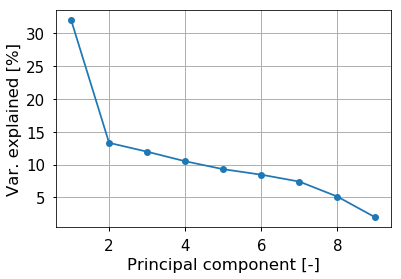

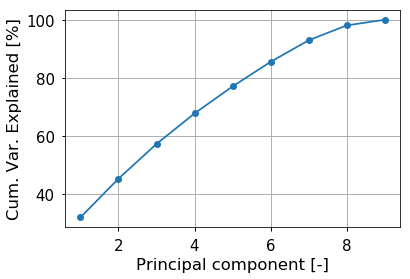

In [11]:
# Define matrix X containing 9 attributes correctly scaled
df_X = data_tr[attribute_names]
X = np.asarray(df_X)

# Perform singular value decomposition
U, S, V = svd(X, full_matrices=False)

# Variance explained
var_explained = S*S / np.sum(S*S)

# Plots of variable explained
plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), var_explained * 100., '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Var. explained [%]')
plt.grid()

plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), np.cumsum(var_explained * 100.), '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Cum. Var. Explained [%]')
plt.grid()

### Principal component directions

From the plots below, it can be seen that the predominant direction corresponds to:
 - a) The typeA feature for the first principal component
 - b) The famhist feature for the second principal component

It can be concluded that the typeA feature is the feature that explains most of the variance in the dataset. 

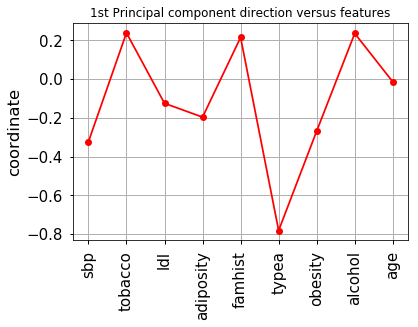

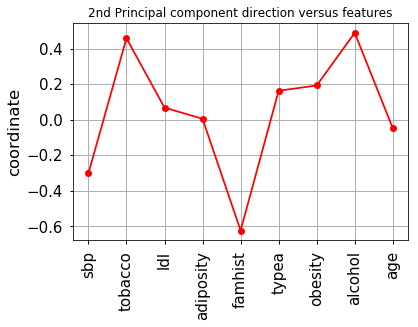

In [12]:
# The eigenvalue vectors or principal components are simply the columns of V, so we transpose V and get the rows.
Vt = V.T

plt.figure()
plt.title('1st Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[0]) + 1), Vt[0], 'ro-')
plt.xticks(np.arange(1,len(Vt[0]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

plt.figure()
plt.title('2nd Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[1]) + 1), Vt[1], 'ro-')
plt.xticks(np.arange(1,len(Vt[1]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

### Dataset projected into the first 2 principal components

The projected data can be computed by simply matrix multiplying the transpose of X with the first two eigenvectors of V respectively. We create two sets of X to account for the 2 existing classes.

It can be seen from the plot that:
 - a) as expected, PC1 shows most of the variability of the data (larger scatter in the x direction)
 - b) Both classes overlap quite a lot (it is difficult to find a 'class splitting' rule)

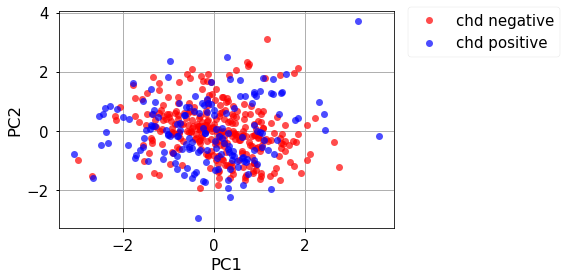

In [13]:
# For plotting purposes, we first create 2 np.ndarrays (X_neg and X_pos) each of them containing a 'chd' class
X_neg = np.asarray(data_tr[attribute_names][data_tr['chd'] == 0])
X_pos = np.asarray(data_tr[attribute_names][data_tr['chd'] == 1])

# 1st component projection
PC1_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[0]).T).flatten()
PC1_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[0]).T).flatten()

# 2nd component projection
PC2_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[1]).T).flatten()
PC2_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[1]).T).flatten()

plt.figure()
plt.plot(PC1_neg, PC2_neg, 'ro', label='chd negative', alpha=0.7)
plt.plot(PC1_pos, PC2_pos, 'bo', label='chd positive', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.grid()

### Summary statistics of attributes

Mean, Std, Median, Max, Min and 25,75 quantiles have been already calculated in the first section using the describe() method. Computing these quantities was useful since we observed differences in scale between certain attributes and also negleted for potential outliers by looking at the max and min values.


### Covariance analysis
We still have not looked into the potential (linear) correlation between the different attributes. We do this by computing the covariance matrix of the scaled matrix X (which is actually equal to the correlation matrix)

From the plot below, it can be seen than:
 - a) the diagonal elements are the actual variances of each attribute which are equal to 1 since we have scaled X by deviding it by the standard deviation.
 - b) the coviariance matrix is symetric so we should inspect the upper of lower part of the matrix
 - c) correlation between attributes is generally low except for:
       - adiposity versus obesity (0.72) --> moderate linear correlation
       - age versus adiposity (0.63) --> some correlation
       - The remaining pairs have correlation below 0.5





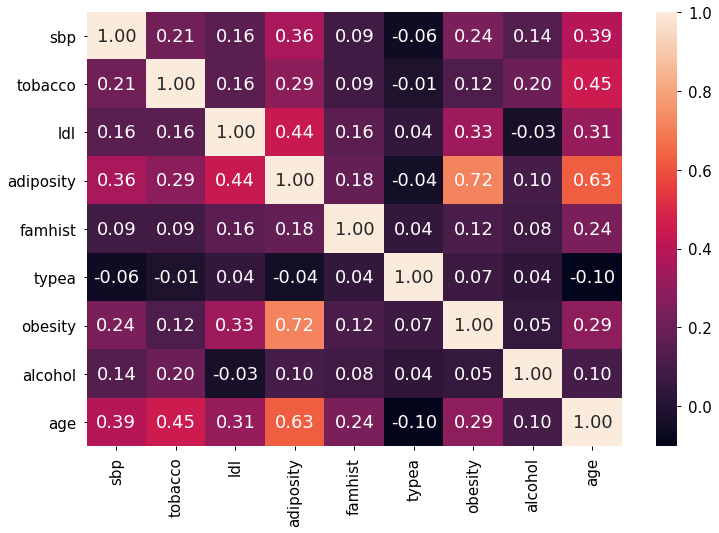

In [14]:
# We Transpose X since the np.cov() function takes each column of X as a single observation
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.cov(X.T), xticklabels=df_X.columns, yticklabels=df_X.columns, annot=True, fmt='.2f')

## Data visualization

#### a) Boxplot for each attribute (scaled)
We can confirm by inspecting this plot that there are no apparent outliers in the data. On the other hand, one can also state that the attributes 'alcohol' and 'tabacco' are highly positively skewed. 

#### b) Histogram of each attribute + attribute pair scatter plots (scaled)
This plot tells us alot. The diagonal shows the staked histogram distributions of each attribute considering the 2 existing classes (chd=1 and chd=0). The non-diagonal plots are scatter plots of pairwise attributes. A simple inspection reveals several aspects about this dataset:
 - age histogram follows a close to uniform distribution (ages are almost represented equally)
 - tabacco and alcohol follow a 'negative exponential distribution'
 - all other histrograms are closer to a gausian distribution (some are skewed however, especially sdp and ldl)
 - the scatter plots show a low correlation between variables in general except for the already mentioned pairs ({obesity, adiposity}, {age, adiposity})
 - the scatter plots reveal that overall both classes are difficult to discern (no clear separation)



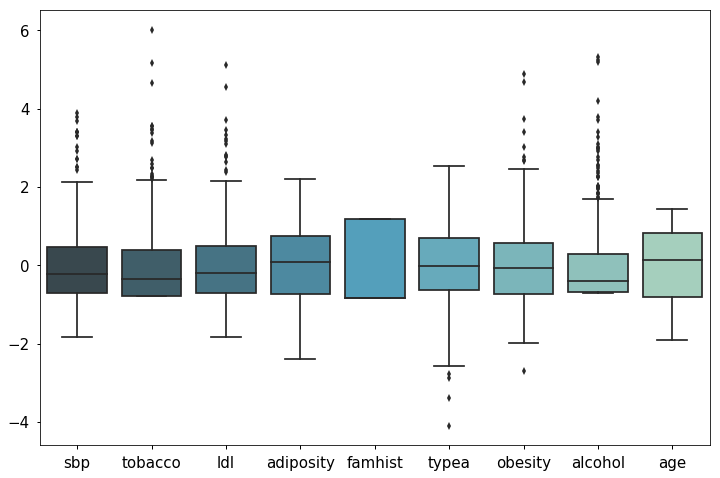

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, data=data_tr[attribute_names],palette='GnBu_d')

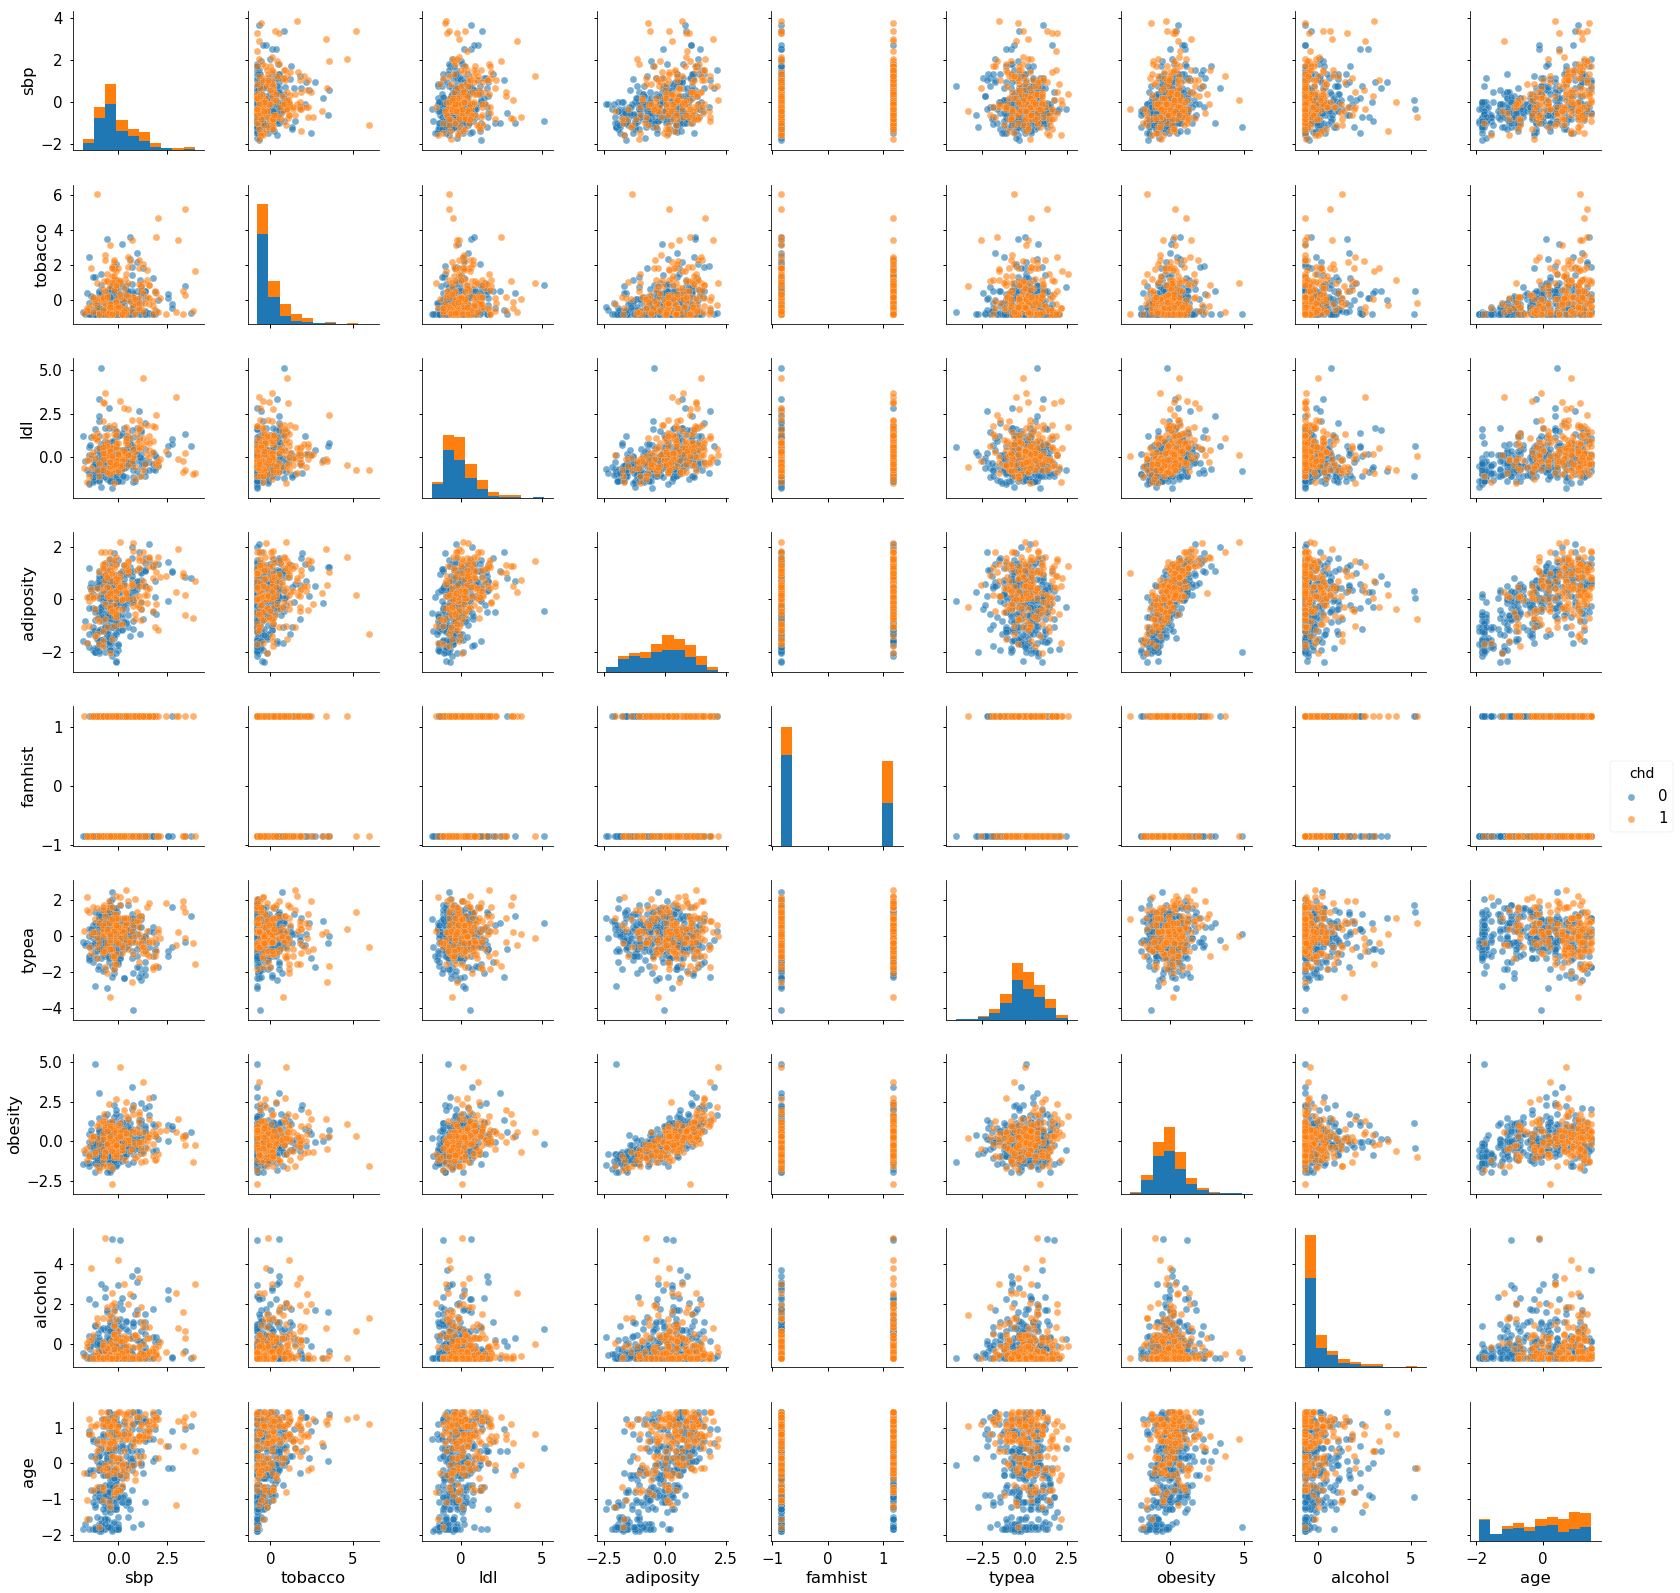

In [16]:
sns.pairplot(data=data_tr, hue='chd',x_vars=attribute_names, y_vars=attribute_names, plot_kws={'alpha': 0.6})

# Supervised learning (classification)

In this section we will assess the performance of different classification supervised machine learning methods when predicting Coronary Heart Disease (chd) based on the 9 available attributes. So in essence:

 - X = {sbp, tabacco, ldl, adiposity, famhist, typea, obesity, alcohol, age}
 - y = chd
 
### Score metric
We use the AUC score (roc_auc in python), to assess performance since our problem suffers from a slight class imbalance.

## Decision trees and 1 layer cross-validation
We apply Hunt's decision tree algorithm and find the optimal tree depth (hyperparameter tunning) using a simple 1 layer cross-validation setup with 10 folds. 

We leave one observation aside for testing and interpreting the final model (fitted on [all the data - 1] using the tree depth that gave the best cross-validation result).

**Results:**
 - Since we use the 'shuffle' option when partitining the data (a good choice here since the data is ordered by the chd label), the end result changes at every code run.
 - After running the code several times, it can be seen that a tree depth of 3 is most often the optimal tree depth yielding an auc score in the range of 0.7
 - If a max tree depth of 3 is used, the testing observation is a true negative. One can interpret this result by following the tree provided in the scketch shown below {True --> False --> True}. One ends up in a leave where 73% of the observations in the training set were classified as 'chd absent'

In [17]:
# Defining the target variable
y = np.asarray(data_tr['chd'])

# We leave the first observation out for testing & interpreting the final model (fitted on
# the entire dataset minus the first observation and using the optimal maximum tree depth found 
# using a 10-fold cross-validation) 
y_final = y[0]
X_final = X[0,:]

X_dtc = X[1:,:]
y_dtc = y[1:]

In [18]:
param_grid ={'max_depth' : np.arange(2, 21, 1)}
CV = StratifiedKFold(n_splits=10, shuffle=True)
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc', cv=CV)
grid_dt.fit(X_dtc, y_dtc)

print('The optimal tree depth is {}.'.format(grid_dt.best_params_['max_depth']))
print('Using the optional tree depth yields an AUC score of {}'.format(np.round(grid_dt.best_score_, 3)))

The optimal tree depth is 3.
Using the optional tree depth yields an AUC score of 0.706


#### On the use of GridSearchCV:
The grid search instance (grid_dt) can also be used for prediction when the GridSearchCV class argument refit is set to True (default setting). In this case, the fit method not only fits to all folds specified in the class and makes predictions for all parameter settings, but it also fits all the provided data (X_dtc, y_dtc) to the best found estimator. When applying the predict method it uses the latter fit to make the prediction.

In [19]:
prediction = grid_dt.predict(X_final.reshape(1,-1))
print('observation:')
print(pd.DataFrame(X_final.reshape(1,-1), columns=attribute_names))
print('\nprediction: {}'.format(int(prediction)))
print('\nobservation: {}'.format(y_final))

observation:
        sbp   tobacco       ldl  adiposity   famhist     typea   obesity  \
0  1.156248  0.362758  1.551567   1.051593  1.185854  0.499251  2.379569   

   alcohol       age  
0 -0.36044  0.355234  

prediction: 0

observation: 0


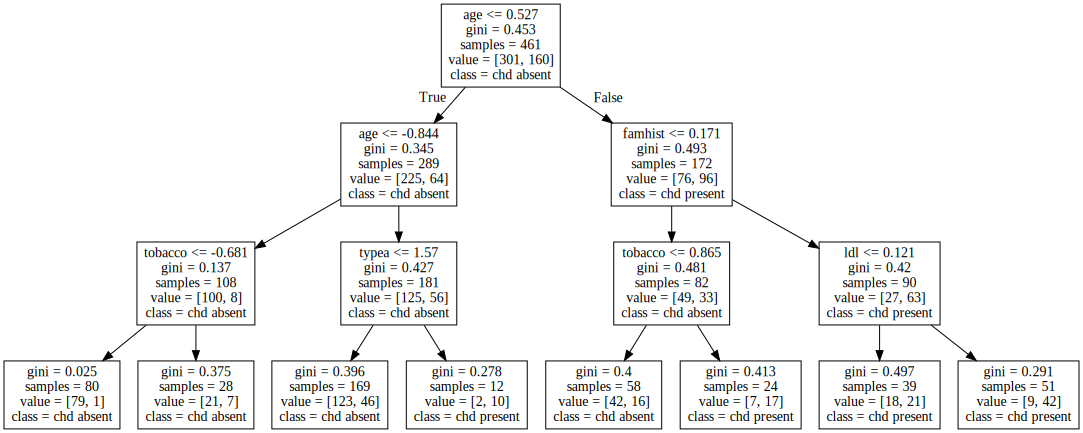

In [20]:
# Tree visualization
out = tree.export_graphviz(grid_dt.best_estimator_, out_file='tree_gini.dot', 
                           feature_names=attribute_names,
                           class_names=['chd absent','chd present'])
with open("tree_gini.dot") as f:
   dot_graph = f.read()
graphviz.Source(dot_graph)

## Comparing classifiers

In this section we estimate the generalization roc_auc score for the 3 following classifiers:
    - Decision tree
    - Naive Bayes
    - K-nearest neighboor (knn)
    
We then evaluate whether the 2 classifiers (out of the 3) that gave the best generalisation roc_auc score are significantly different (in other words, if one is better than the other).


We estimate the generalization error in a 2 layer cross validation setup where the inner layer is used for selecting the best parameter settings for each outer fold.

In [21]:
# 2 layer cross-validation settings (common to all three models); we don't use the shuffle option here since 
# we need the same train and test indexes for the 3 models when comparing them.
K = 10
inner_cv = StratifiedKFold(n_splits=K)
outer_cv = StratifiedKFold(n_splits=K)

### knn generalization roc_auc estimate

In [22]:
param_grid_knn = {'n_neighbors' : np.array([3,5,11,21,51,71,101]),
                  'metric' : ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, scoring='roc_auc', cv=inner_cv)
nested_scores_knn = cross_val_score(grid_knn, X=X, y=y, cv=outer_cv)
print('knn generalization roc_auc estimate: {0}'.format(np.round(nested_scores_knn.mean(),3)))
print('std of knn generalization roc_auc: {0}'.format(np.round(nested_scores_knn.std(),3)))

knn generalization roc_auc estimate: 0.764
std of knn generalization roc_auc: 0.075


### Decision tree generalization roc_auc estimate

In [23]:
param_grid_dt = {'max_depth' : np.arange(2, 21, 1),
                 'criterion' : ['gini', 'entropy']}

grid_dt = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid_dt, scoring='roc_auc', cv=inner_cv)
nested_scores_dt = cross_val_score(grid_dt, X=X, y=y, cv=outer_cv)
print('decision tree generalization roc_auc estimate: {0}'.format(np.round(nested_scores_dt.mean(),3)))
print('std of decision tree generalization roc_auc: {0}'.format(np.round(nested_scores_dt.std(),3)))

decision tree generalization roc_auc estimate: 0.707
std of decision tree generalization roc_auc: 0.056


### Naive-Bayes generalization error estimate

In order to properly apply the Naive-Bayes estimator on the data we first need to inspect our features and check:
 - if they are discrete/continuous
 - the distribution of each of the features independently
 
The algorithm requires discrete features for estimating the conditional probabilities p(xi|y=c), so in case the data is not discrete there are two options:
 - binning the data 
 - approximate each feature by a univariate gaussian density distribution
 
In the first case, the sklearn estimator MultinomialNB() would be used and in the second we would use GaussianNB().


When inspecting our features it turns out that the features types is mixed. All except for **famhist** are continuous attributes. Moreover, when inspecting the pairplot of all variables (see above), it can be seen that the distribution of most of the features is not Gaussian. It is therefore more convenient to bin the data instead of approximating it with a Gaussian density probability distribution.

#### Applying feature transformation

In the following section we make use of sklearn's transformer class **FunctionTransformer** and we define our own transformer for subsetting the features. We use sklearn's Pipeline and FeatureUnion functionalities to concatenate all the feature transformation steps smoothly. The resulting pipe is named **preprocess**.

#### GridSearch through preprocessing and estimator parameters

We define a new Pipeline (**pipe_nb**) containing the preprocessing pipe and the MultinomialNB estimator
and search for the best sets of hyperparameters when varying:
 - the number of bins to be used when binning the features (except for famhist which the binning is set to 2)
 - the additive Laplace smoothing parameter

We do this in a 2 layer cross-validation setup like we did for the knn and decision tree models. It is interesting to point out that the GridSearchCV class also allows to 'grid search' on transformer parameters which becomes extremely useful (all can be done in one go).

In [24]:
class FilterExtractor(BaseEstimator, TransformerMixin):
    """Subset rows/columns using DataFrame.filter"""
    
    def __init__(self, regex=None, items=None, like=None, axis=1):
        self.regex = regex
        self.items = items
        self.like = like
        self.axis=axis
    
    def transform(self, X):
        subset = X.filter(regex=self.regex,items=self.items,like=self.like, axis=self.axis)
        return subset
    
    def fit(self, X, *_):
        return self
    
def bin_digitize(X, bins=10):
    df = pd.DataFrame(X)
    for col in df.columns:
        nbins = np.linspace(df[col].min(), df[col].max(), bins)
        df[col] = np.digitize(df[col], nbins)
    return df.values

def mapping_list(array, key='bins'):
    out=[]
    for i in array:
        out.append({key : i})
    return out

In [25]:
select_cols = [col for col in df_X.columns if col != 'famhist']

bin_cont = [('select', FilterExtractor(items=select_cols)), 
            ('transform', FunctionTransformer(func=bin_digitize))]

bin_disc = [('select', FilterExtractor(items=['famhist'])), 
            ('transform', FunctionTransformer(func=bin_digitize, kw_args={'bins':2}))]
            
pipe1 = Pipeline(bin_cont)
pipe2 = Pipeline(bin_disc)
preprocess = FeatureUnion([('cont_attr', pipe1), ('disc_attr', pipe2)])

pipe_nb = Pipeline([('preprocess', preprocess),('nb', MultinomialNB())])

param_grid_nb = {'nb__alpha' : np.array([0.5, 0.75, 1]),
                 'preprocess__cont_attr__transform__kw_args' : mapping_list(np.arange(20,60,10))}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, scoring='roc_auc', cv=inner_cv)
nested_scores_nb = cross_val_score(grid_nb, X=df_X, y=y, scoring='roc_auc', cv=outer_cv)

print('Naive Bayes generalization roc_auc estimate: {0}'.format(np.round(nested_scores_nb.mean(),3)))
print('std of Naive Bayes generalization roc_auc: {0}'.format(np.round(nested_scores_nb.std(),3)))

Naive Bayes generalization roc_auc estimate: 0.664
std of Naive Bayes generalization roc_auc: 0.068


#### Storing classifer roc_auc results in a dataframe

In [26]:
scores = [nested_scores_knn, nested_scores_dt, nested_scores_nb]

fold_columns = ['fold{0}'.format(i) for i in np.arange(1,11)]
classifier_df = pd.DataFrame(scores, columns=fold_columns, index=['knn', 'Decision tree', 'Naive-Bayes'])
classifier_df['mean'] = classifier_df.mean(axis=1)
classifier_df['std'] = classifier_df.std(axis=1)
classifier_df

,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean,std
knn,0.676411,0.810484,0.707292,0.694792,0.875000,0.792708,0.747917,0.779167,0.668750,0.890625,0.764315,0.075218
Decision tree,0.702621,0.725806,0.734375,0.651042,0.745833,0.719792,0.758333,0.721875,0.561458,0.748958,0.707009,0.056325
Naive-Bayes,0.616935,0.727823,0.606250,0.656250,0.789583,0.687500,0.735417,0.668750,0.560417,0.595833,0.664476,0.068194


Text(0,0.5,'roc_auc score')

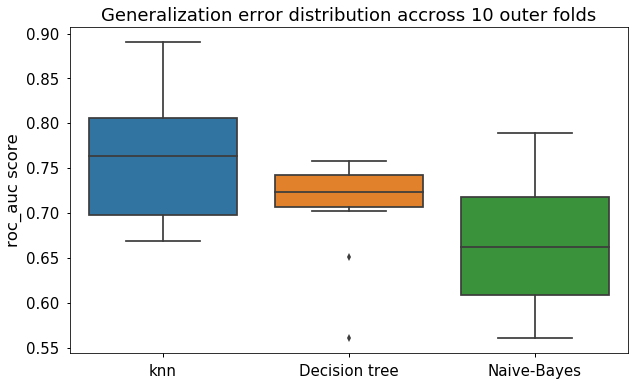

In [27]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=classifier_df[classifier_df.columns[:-2]].T)
ax.set_title('Generalization error distribution accross {} outer folds'.format(K))
ax.set_ylabel('roc_auc score')

#### Comparing the knn and Decision tree classifiers

We compute the 95% credibility interval of the difference of the generalization roc_auc scores of the 2 classifiers. The two confidence bands are larger than zero so it can be concluded that the knn classifier is better than the Decision tree classifier with a 95% credibility.

In [28]:
z = classifier_df.loc['knn', fold_columns] - classifier_df.loc['Decision tree', fold_columns]
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')

Classifiers are significantly different.


# Supervised learning (regression)

In this section we will investigate the performance of different supervised learning regression models in predicting obesity. We will use the attributes shown below (we exclude the boolean variable famhist) and will also investigate potential transformations of the attributes (polynomial form or interaction form terms). So in essence:

 - X = {sbp, tobacco, ldl, adiposity, typea, alcohol, age}
 - y = obesity
 
### Linear regression
We use a 2 layer Cross Validation setup using forward feature selection in the inner CV fold for model selection.
We evaluate the mean square test error (MSE) accross all outer cross-validation folds (best approximation of the generalization error) in two scenarios:
   - using feature selection
   - without using feature selection
   
For this we test different sets of attributes in the following order:
   - 1) all attributes without including any transformations
   - 2) all attributes including polynomial transformations of the most relevant attributes found in 1)
   - 3) Most relevant set of attributes found in 2) including interaction terms.
   
We leave a small number of observations (max 20) out of the dataset which is in the last stage used to interpret and test the final model.
  
__Results:__
   - When performing step 1), we observe that the most relevant attributes are (in order): __{adiposity, age, typea}__
   - The MSE in 1) including feature selection (which in 4 out of 5 folds takes adiposity, age and typea attributes only)  is around 0.45. The MSE is only slightly higher when including all attributes (0rd(-3) higher) which suggest that the non-selected attributes have very small weights in the linear model.
   - In 1) we observe that the apidosity residuals (most relevant feature) have a slight curvature which suggests that adding adiposity polynomial transformations into the algorithm might improve results. The same can be said about the age attribute.
   - It was found that including the square of adiposity and the cube of age increased model performance (MSE accross all CV folds goes down to 0.42). It is nonetheless not a big improvement.
   - Including the interaction term between age and adiposity was tested but this did not lead to an improvement of the MSE. 
   - The best model thus is constructed using the following attributes (sorted by order of relevance):
     __{adiposity, age, adiposity^2, age^3, typea}__

In [29]:
# redefining target and attribute variables 
y_lr = df_X['obesity']
cols_lr = [col for col in df_X.columns if col not in ['famhist', 'obesity']]
X_lr = df_X[cols_lr]

In [30]:
# adding transformations which are also scaled by mean and standard deviation
power_dict = {'adiposity' : [2], 'age' : [3]}
X_lr = lreg.transform_attributes(X_lr, power_dict=power_dict, standard_scaler=True)

In [31]:
# Number of observations to test the model
m = 10

# Splitting test and model dataframes
X_lr_model = X_lr.loc[m:, X_lr.columns]
y_lr_model = y_lr[m:]

X_lr_test = X_lr.loc[0:(m-1), X_lr.columns] 
y_lr_test = y_lr[0:m]

X_lr_model.head()

,sbp,tobacco,ldl,adiposity,typea,alcohol,age,p(adiposity)2,p(age)3
10,-0.211332,-0.792417,-1.131320,-0.552828,0.397282,-0.640960,-1.700527,-0.609259,-2.059444
11,-0.309016,-0.792417,-1.817753,-0.516803,0.907127,-0.696983,0.697861,-0.643069,0.326982
12,-1.090491,-0.138545,-0.817108,0.630867,-1.234222,-0.661815,0.081133,-0.528209,0.172954
13,0.277089,-0.792417,-0.275697,0.543376,-0.112563,-0.696983,1.109013,-0.618350,0.791846
14,-0.211332,-0.781519,1.590239,0.327223,-0.520439,-0.696983,1.177539,-0.783463,0.913851


In [32]:
df_features, df_error, feature_record_list, loss_record_list = lreg.lreg_2lcv_fs(X_lr_model, y_lr_model)

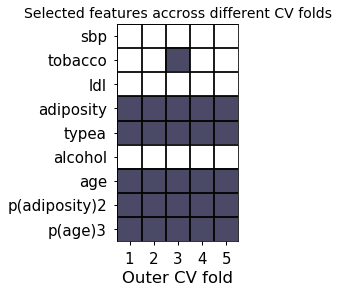

In [33]:
lreg.bmplot(df_features.index, np.arange(1, len(df_features.columns) + 1), -np.asarray(df_features))
plt.xlabel('Outer CV fold')
plt.title('Selected features accross different CV folds', size=14)
plt.clim(-1.5,0)

In [34]:
df_error

,error_train,error_test,error_train_fs,error_test_fs,error_train_nf,error_test_nf
CVFold1,0.431202,0.308619,0.434049,0.303053,1.043130,0.762695
CVFold2,0.421787,0.338840,0.422936,0.339596,0.997669,0.943020
CVFold3,0.418698,0.355348,0.419655,0.354385,0.959677,1.087625
CVFold4,0.437173,0.274408,0.438736,0.275355,0.995760,0.938522
CVFold5,0.299644,0.845964,0.302514,0.839755,0.936603,1.187975
mean_error,0.401701,0.424636,0.403578,0.422429,0.986568,0.983967
r2,0.592830,0.566947,0.590927,0.569184,0.000000,0.000000


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

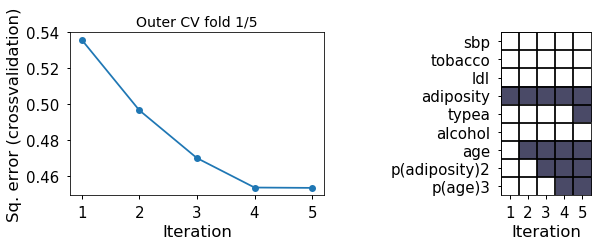

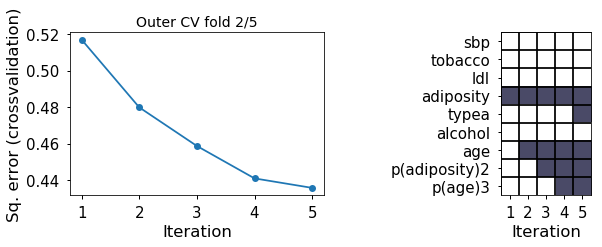

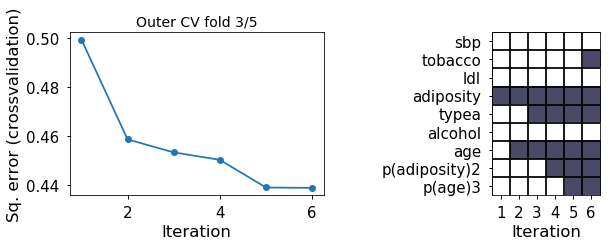

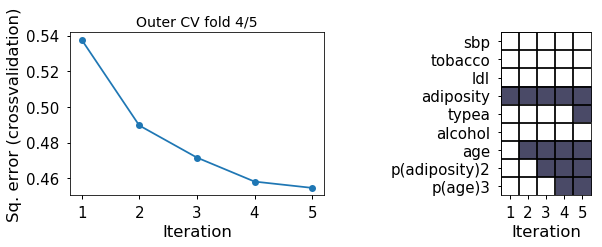

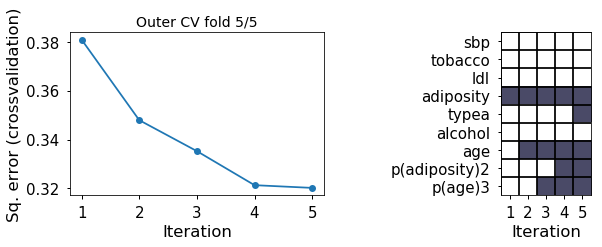

In [35]:
lreg.plot_lr_record(df_features, feature_record_list, loss_record_list)
plt.figure

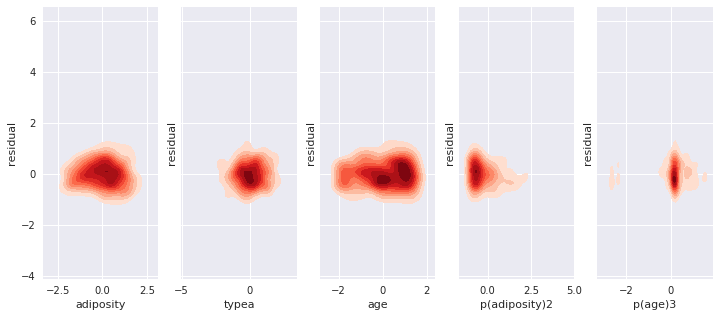

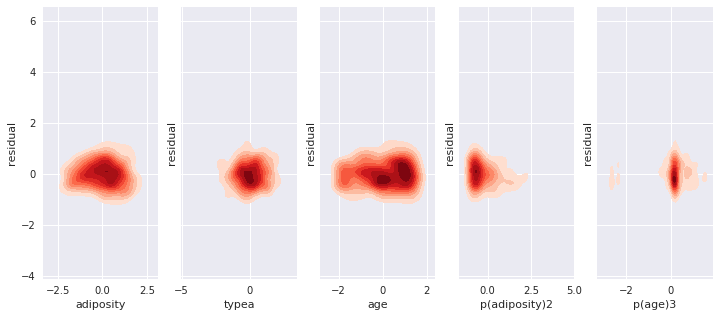

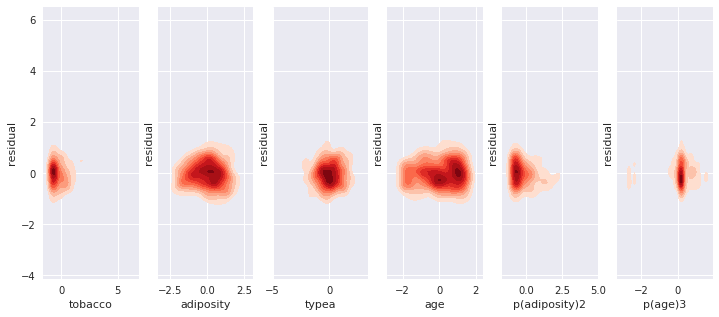

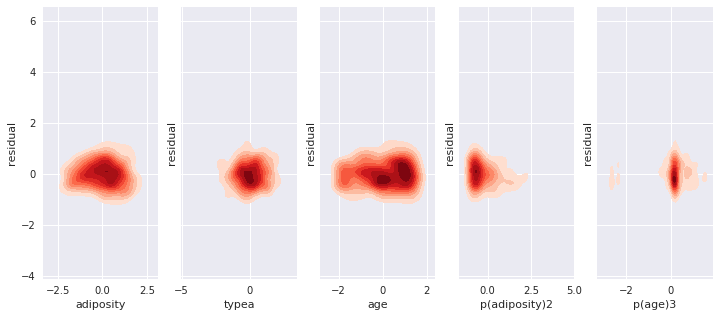

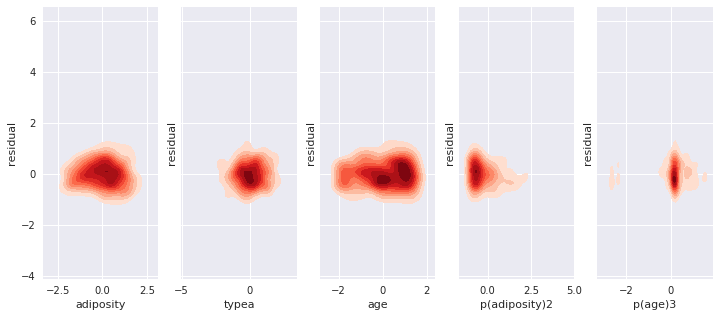

In [36]:
lreg.inspect_cvfold_residuals(X_lr_model, y_lr_model, df_features, figsize=(12,5))

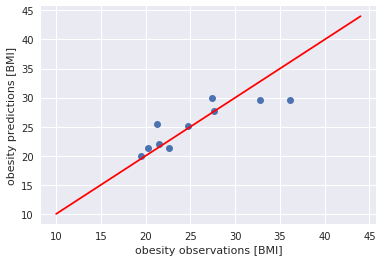

In [37]:
# Fit and test the new model considering the best features

best_features = ['adiposity','age','p(adiposity)2', 'p(age)3', 'typea']
mdl = lm.LinearRegression(fit_intercept=True).fit(X_lr_model[best_features], y_lr_model)
y_lr_predict = mdl.predict(X_lr_test[best_features])

# Rescale obesity back to the original scale
mean_obesity = data['obesity'].mean()
std_obesity = data['obesity'].std()
y_lr_predict_scaled = (y_lr_predict * std_obesity) + mean_obesity 
y_lr_test_scaled = (y_lr_test * std_obesity) + mean_obesity

plt.plot(y_lr_test_scaled, y_lr_predict_scaled, 'o')
plt.xlabel('obesity observations [BMI]')
plt.ylabel('obesity predictions [BMI]')
plt.plot(np.arange(10,45), np.arange(10,45), 'r-')

As expected, the largest linear regression coefficients (in absolute value) are the adiposity and age terms.

In [38]:
w_series = pd.Series()
w_series['w0'] = mdl.intercept_
w_coefs = mdl.coef_
w_names = ['w_{}'.format(col) for col in best_features]
for i, w in enumerate(w_names):
    w_series[w] = w_coefs[i]

w_series

w0                -0.000819
w_adiposity        0.873759
w_age             -0.485076
w_p(adiposity)2    0.170437
w_p(age)3          0.301334
w_typea            0.071089
dtype: float64

##  Ridge, Art. Neural network (1 hidden layer, feedforward) & Lasso model comparison in regression

We compute the generalization mse (mean square error) of these three models and compare these results with the mse of a simple 'average' regressor (named Naive regressor from now) that takes the mean of the training target values as estimate. This model is used as our performance reference model. 

We then access if the 2 best performing models (in terms of generatiation mse mean) are significantly different or not using confidence interval reasoning (t-Student distribution).

#### Data
The same dataset used in the linear regression model with forward feature selection.

In [39]:
y_reg = data['obesity'].values
X_reg = data[[col for col in data.columns if col not in ['obesity', 'chd', 'row.names']]].values

#### 2-layer CV setup

We use 10 fold cross-validation for the outer folds for all models and we do not shuffle the data. This
allows models to be compared using the same training/testing data.

In the inner layer, we take 10 folds for the Lasso and Ridge regression models and only 1 fold (holdout) 
for the ANN since it becomes too computationally demanding otherwise.

In [40]:
K_outer = 10
K_inner = 10

cv_inner_reg = KFold(n_splits=K_inner)
cv_outer_reg = KFold(n_splits=K_outer)

### Naive Regressor generalization MSE

We simply take the average of the y training data as our y estimate in each outer cross-validation fold (no inner cross-validation since there is no parameter tunning) and we compare these estimates with the testing y data.

In [41]:
error_naive = []
for train_index, test_index in cv_outer_reg.split(X_reg):
    
    y_train = y_reg[train_index]
    y_test = y_reg[test_index]
    y_est = y_train.mean() * np.ones(len(y_test))
    error_naive.append(mse(y_test, y_est))
error_naive = np.array(error_naive)
print(error_naive)
print('Naive regressor generalization MSE is: {0}'.format(np.round(error_naive.mean(), 3)))

[23.73090457 21.00008559 18.1232166  17.37568495 16.47583498 18.15646105
 16.35343339 11.04886835 17.86207397 18.35165935]
Naive regressor generalization MSE is: 17.848


### Ridge regression generalization MSE

We use a Pipeline to stack a scaling transformer and the Ridge regression estimator. We estimate the optimal regularization parameter (alpha) using the inner cv folds for each outer fold. The generalization MSE is estimated taking the mean of the best performing models evaluated in the outer folds. Once again we use sklearn's GridSearch and cross_val_score for this calculation.

In [42]:
pipe_ridge = Pipeline(steps=[('scale', StandardScaler()),('ridge', Ridge())])

alphas = {'ridge__alpha' : np.array([1e-6, 1e-4, 1e-2, 1e-1 ,1, 10, 50, 100])}
grid_rd = GridSearchCV(pipe_ridge, param_grid=alphas, scoring='neg_mean_squared_error', cv=cv_inner_reg)
nested_scores_rd = cross_val_score(grid_rd, X=X_reg, y=y_reg, scoring='neg_mean_squared_error', 
                                   cv=cv_outer_reg)
print(nested_scores_rd*-1)
print('Ridge regression generalization MSE is: {0}'.format(np.round(-nested_scores_rd.mean(),3)))

[21.57662659  7.52304408  6.44789796  5.91366934  5.18788706  7.33661752
  5.78738947  5.27886193  5.19746574  9.82815764]
Ridge regression generalization MSE is: 8.008


### Lasso regression generalization MSE

Same technique for cross-validation is used here. The regularization parameter alpha is the only parameter tunned in the inner cv folds.

In [43]:
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline(steps=[('scale', StandardScaler()),('lasso', Lasso())])

alphas_l = {'lasso__alpha' : np.array([1e-8, 1e-6, 1e-4, 1e-2, 1e-1 ,1, 10, 50])}
grid_ls = GridSearchCV(pipe_lasso, param_grid=alphas_l, scoring='neg_mean_squared_error', cv=cv_inner_reg)
nested_scores_ls = cross_val_score(grid_ls, X=X_reg, y=y_reg, scoring='neg_mean_squared_error', 
                                   cv=cv_outer_reg)
print(nested_scores_ls*-1)
print('Lasso regression generalization MSE is: {0}'.format(np.round(-nested_scores_ls.mean(),3)))

[21.55538632  7.50540325  6.43019356  5.95386791  5.29572004  7.73640397
  5.8302751   5.27720459  5.1971067   9.81024115]
Lasso regression generalization MSE is: 8.059


### Multi-Layer Perceptron (ANN) setup

Sklearn's MLPRegression class in used here.

Fitting a feedforward multi-layer perceptron suffers from the problem of local minimas. We overcome this by using a fitting strategy that fits the model to the same data using several random initialization of model weight. This is controled by the parameter n_train. The model that yields the smallest error loss (E(w)) is kept for later prediction. 

A drawback which result from this is that one can no longer use sklearn's *GridSearchCV* in combination with *cross_val_score* to easily compute the generalization error since these methods use the default fit method. Nonetheless, one could potentially overcome this by defining a new estimator which would inherit from the MLPRegression class and code up a new *fit* method that would overwrite the default one. 

This path was not pursued here; in contrast, and for the sake of model control, the inner an outer loops were coded manually using a new custom fit method (*fit_ann*) and relevant modelling info is logged (using the hierarchy from the logging module).

### ANN 2-layer CV strategy

We use a holdout validation fold in the inner loop due to computational constraints. This is achieved using the developed *optimal_ann_holdout* function which essencially returns the best model hyperparameter set after an exaustive search using the holdout method. this function takes a parameter grid dictionary as input (mimics the behavior of *GridSearchCV*).

The outer loop uses the same partitioning then the other regression models (for the sake of model performance comparison)

### ANN settings

In [76]:
# ann solver strategy settings:
ann_args = {'max_iter'   : 7000,
            'tol'        : 1e-5,
            'solver'     : 'lbfgs',
            'verbose'    : False,
            'activation' : 'tanh'}

# Number of ann trainings using different weight initializations. 
# NOTE: This is done in order to avoid finding a local minima as solution.
# The solution with the lower loss (or training error) in the n_train ann trainings is kept.
n_train = 5

# MLPREgressor parameter grid for serching best model in inner holdout loop
param_grid = {'hidden_layer_sizes' : [(1,), (2,), (4,), (6,)]}

# Transformer(s) to apply to the data before calling the ann estimator (as a list of tuples)
transformers = [('scale', StandardScaler())]
    
# Logger debug level
debug_level='CRITICAL'

# show prediction plots
show_plots = False

### ANN 2 layer Cross-validation loop and generalization mse estimate


===== FINAL RESULTS =====
ANN Generalization MSE error estimate is 7.61
std of ANN Generalization MSE error is 5.26


[10.7835261  22.0038849   4.24119332  6.80510104  8.49609473  5.61738501
  3.28132149  5.97057625  5.47827464  3.46780468]


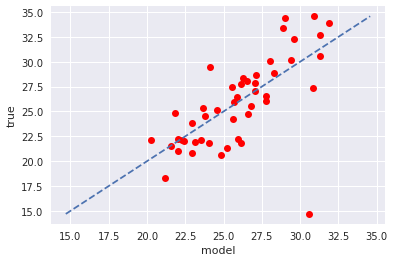

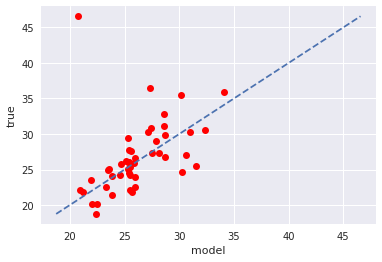

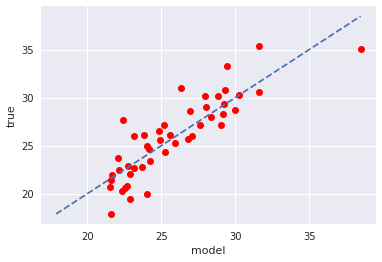

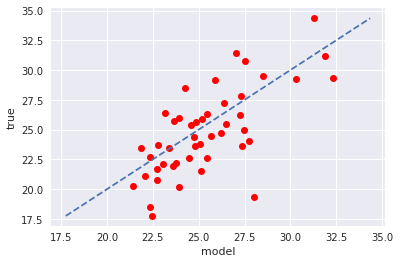

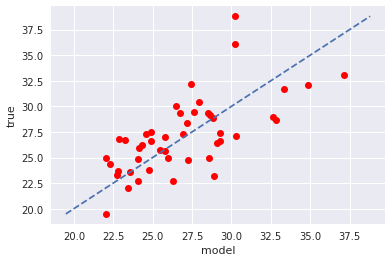

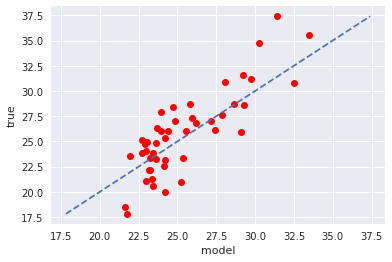

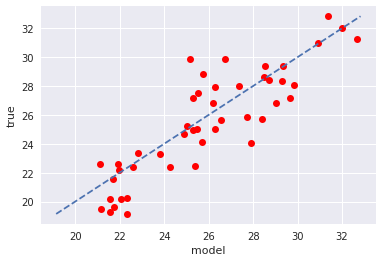

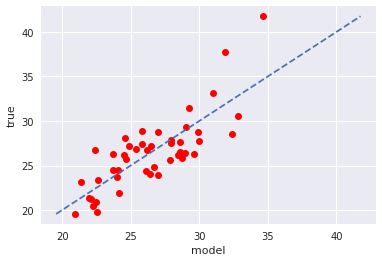

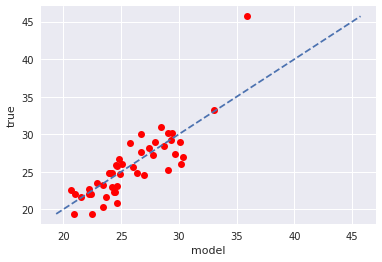

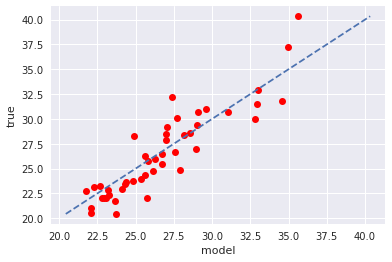

In [75]:
# Create logger
logger = gen_logger(verb=debug_level)

# Main loop
k = 0
error_final = []
for train_index, test_index in cv_outer_reg.split(X_reg):
    
    X_train, y_train = X_reg[train_index], y_reg[train_index]
    X_test, y_test = X_reg[test_index], y_reg[test_index]
    
    logger.warning('\n=========== Crossvalidation fold: {0}/{1} ==========='.format(k+1,K_outer))
    
    # Finding best model parameters in inner holdout loop
    best_params = net.optimal_ann_holdout(X_train, 
                                          y_train,
                                          param_grid,
                                          logger,
                                          transformers=transformers,
                                          n_train=n_train,
                                          **ann_args) 
    # Optimal Model
    ann = MLPRegressor(**best_params)
         
    # Create Pipeline using the standard scaler transformer
    pipe_final = Pipeline(steps=transformers + [('ann', ann)])
    
    # Fit model to training data
    logger.warning('\nFitting best model on outer CV fold {}/{}...'.format(k+1, K_outer))
    bestnet = net.fit_ann(X_train, y_train, n_train, pipe_final, logger, joblibfile='ann_outer.pkl')
    
    # Make prediction with best ann model and store mse error
    y_est = bestnet.predict(X_test)
    error_final.append(mse(y_test, y_est))
    k+=1
    
    if show_plots:
        plt.figure()
        max_ = np.array(list(y_est) + list(y_test)).max()
        min_ = np.array(list(y_est) + list(y_test)).min()    
        plt.plot(y_est, y_test,'ro')
        plt.plot((min_, max_),(min_, max_), '--')
        plt.xlabel('model')
        plt.ylabel('true')

error_final = np.array(error_final)
print(error_final)
logger.critical('\n===== FINAL RESULTS =====')
logger.critical('ANN Generalization MSE error estimate is {}'.format(np.round(error_final.mean(), 2)))
logger.critical('std of ANN Generalization MSE error is {}'.format(np.round(error_final.std(), 2)))

In [ ]:
# errors_reg = pd.DataFrame()
